In [1]:
!pip install --upgrade tensorflow --user
!pip install tf-quant-finance
!pip install QuantLib-Python

In [2]:
import os
# reduce number of threads
os.environ['TF_NUM_INTEROP_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tf_quant_finance as tff 
import tensorflow as tf
import functools
import pandas as pd
import time
import QuantLib as ql

In [3]:
!nvidia-smi

Tue Apr 12 13:30:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#@title Set up parameters

dtype = tf.float64 #@param
num_samples = 200000 #@param
num_timesteps = 100#100 #@param
nb_options = 20

# expiries =tf.constant( [0.0, 0.5, 1.0], dtype=dtype) # This can be a rank 1 Tensor
dt = 1. / num_timesteps
times = [1.0]
# times = tf.linspace(tf.constant(0.0, dtype=dtype), tf.constant(1.0, dtype=dtype), num_timesteps)
rate = tf.constant(0.03, dtype=dtype)
sigma = tf.constant(0.1, dtype=dtype)
spot = tf.constant(700, dtype=dtype)
strikes = tf.linspace(0.5*spot, 1.5*spot, nb_options)

def set_up_pricer(times, watch_params=False):
    """Set up European option pricing function under Black-Scholes model.
    
    Args:
        expiries: List of expiries at which to to sample the trajectories.
        watch_params: A Python bool. When `True`, gradients of the price function wrt the inputs
          are computed more efficiently. 
    Returns:
     A callable that accepts a rank 1 tensor of strikes, and scalar values for 
     the spots and  volatility values. The callable outputs prices of
     the European call options on the grid `expiries x strikes`.
    """
    def price_eu_options(strikes, spot, sigma):
        # Define drift and volatility functions. 
        def drift_fn(t, x):
          del t, x
          return rate - 0.5 * sigma**2
        def vol_fn(t, x):
          del t, x
          return tf.reshape(sigma, [1, 1])
        # Use GenericItoProcess class to set up the Ito process
        process = tff.models.GenericItoProcess(
            dim=1,
            drift_fn=drift_fn,
            volatility_fn=vol_fn,
            dtype=dtype)
        log_spot = tf.math.log(tf.reduce_mean(spot))
        if watch_params:
            watch_params_list = [sigma]
        else:
            watch_params_list = None
        paths = process.sample_paths(
            times=times, num_samples=num_samples,
            initial_state=log_spot, 
            watch_params=watch_params_list,
            # Select a random number generator
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)
        prices = (tf.exp(-tf.expand_dims(rate * times, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(tf.math.exp(paths) - strikes), 0))
        return prices
    return price_eu_options

price_eu_options = tf.function(set_up_pricer(times, watch_params=True),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ])
price_eu_options_xla = tf.function(set_up_pricer(times, watch_params=True),
                               input_signature=[
                                                tf.TensorSpec([None], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64),
                                                tf.TensorSpec([], dtype=tf.float64)
                               ], jit_compile=True)
# price_eu_options_xla = tf.function(set_up_pricer(times), jit_compile=True)
# price_eu_options = set_up_pricer(times)
# price_eu_options_xla = set_up_pricer(times)

In [5]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu', time_price_cpu, nb_options/time_price_cpu)


[[3.60348102e+02 3.24594845e+02 2.88841589e+02 2.53088355e+02
  2.17336702e+02 1.81604304e+02 1.46028421e+02 1.11214322e+02
  7.86692885e+01 5.06996767e+01 2.93302686e+01 1.50968846e+01
  6.89224959e+00 2.80422513e+00 1.01489007e+00 3.30091498e-01
  9.79873801e-02 2.86262081e-02 8.16632897e-03 2.07839435e-03]]
time_price_cpu_nograph 10.476874113082886 1.908966337108624
time_price_gpu_nograph 3.848632335662842 5.1966512401490395
time_price_gpu0 29.24185585975647 0.6839511177375239
time_price_gpu 0.6242570877075195 32.03808237635984
time_price_cpu0 3.111023187637329 6.428753112312553
time_price_cpu 2.8909430503845215 6.918157726192434


In [6]:
#@title Pricing times on CPU and GPU platforms

time_start = time.time()
with tf.device("/cpu:0"):
    price_cpu_nograph = set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_cpu_nograph = time_end - time_start
print(price_cpu_nograph[:10].numpy())

time_start = time.time()
with tf.device("/gpu:0"):
    set_up_pricer(times)(strikes, spot, sigma)
time_end = time.time()
time_price_gpu_nograph = time_end - time_start

# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
time_end = time.time()
time_price_cpu = time_end - time_start

print('time_price_cpu_nograph', time_price_cpu_nograph, nb_options/time_price_cpu_nograph)
print('time_price_gpu_nograph', time_price_gpu_nograph, nb_options/time_price_gpu_nograph)

print('time_price_gpu0 XLA', time_price_gpu0, nb_options/time_price_gpu0)
print('time_price_gpu XLA', time_price_gpu, nb_options/time_price_gpu)

print('time_price_cpu0 XLA', time_price_cpu0, nb_options/time_price_cpu0)
print('time_price_cpu XLA', time_price_cpu, nb_options/time_price_cpu)


[[3.60347632e+02 3.24594375e+02 2.88841119e+02 2.53087862e+02
  2.17336125e+02 1.81606871e+02 1.46036412e+02 1.11223927e+02
  7.86627524e+01 5.06780933e+01 2.92983254e+01 1.50755770e+01
  6.88869416e+00 2.81306504e+00 1.03317688e+00 3.45211687e-01
  1.10239128e-01 3.16514260e-02 8.57859991e-03 1.62875294e-03]]
time_price_cpu_nograph 3.25045108795166 6.152992141347194
time_price_gpu_nograph 1.2309410572052002 16.24773167076672
time_price_gpu0 XLA 1.3789706230163574 14.5035722053687
time_price_gpu XLA 0.014405012130737305 1388.405633989308
time_price_cpu0 XLA 1.6360692977905273 12.224421072511735
time_price_cpu XLA 1.1982505321502686 16.69100030701415


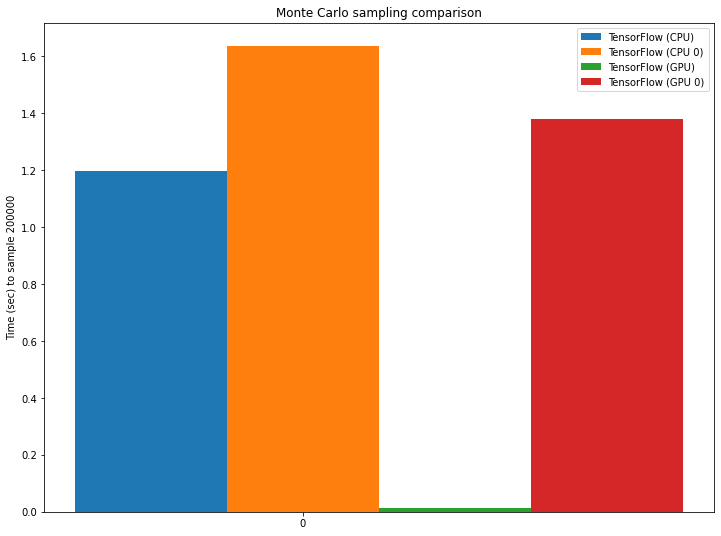

In [7]:
#@title Plot the results

ind = np.arange(1)  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

fig.set_figheight(9)
fig.set_figwidth(12)

ax.bar(ind - width/8, [time_price_cpu], width / 8,
       label='TensorFlow (CPU)')
ax.bar(ind, [time_price_cpu0], width / 8,
       label='TensorFlow (CPU 0)')
ax.bar(ind + width/8, [time_price_gpu], width / 8,
       label='TensorFlow (GPU)')
ax.bar(ind + width/4, [time_price_gpu0], width / 8,
       label='TensorFlow (GPU 0)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (sec) to sample {}'.format(num_samples))
ax.set_title('Monte Carlo sampling comparison')
ax.set_xticks(ind)
ax.legend()


plt.show()

In [8]:
# Delta
@tf.function
def delta_fn(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function
def vega_fn(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)



# Delta
@tf.function(jit_compile=True)
def delta_fn_xla(spot):
    fn = lambda spot: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, spot,
                                 use_gradient_tape=True)
# Theta # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Rho # not tested in https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Monte_Carlo_Euler_Scheme.ipynb
# Vega
@tf.function(jit_compile=True)
def vega_fn_xla(sigma):
    fn = lambda sigma: price_eu_options(strikes, spot, sigma)
    return tff.math.fwd_gradient(fn, sigma,
                                 use_gradient_tape=True)

In [9]:
# Delta CPU
## warmup
with tf.device("/cpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    deltas_cpu = delta_fn(spot)
time_end = time.time()
time_delta_cpu = time_end - time_start


# Vega CPU
## warmup
with tf.device("/cpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/cpu:0"):
    vegas_cpu = vega_fn(sigma)
time_end = time.time()
time_vega_cpu = time_end - time_start


# Delta GPU
## warmup
with tf.device("/gpu:0"):
    delta_fn(spot)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    deltas_gpu = delta_fn(spot)
time_end = time.time()
time_delta_gpu = time_end - time_start

# Vega GPU
## warmup
with tf.device("/gpu:0"):
    vega_fn(sigma)
## measure time
time_start = time.time()
with tf.device("/gpu:0"):
    vegas_gpu = vega_fn(sigma)
time_end = time.time()
time_vega_gpu = time_end - time_start



print('time_delta_cpu', time_delta_cpu, nb_options/time_delta_cpu)
print('time_vega_cpu', time_vega_cpu, nb_options/time_vega_cpu)
print('time_delta_gpu', time_delta_gpu, nb_options/time_delta_gpu)
print('time_vega_gpu', time_vega_gpu, nb_options/time_vega_gpu)

print(deltas_cpu)
print(vegas_cpu)
print(deltas_gpu)
print(vegas_gpu)

time_delta_cpu 7.554673194885254 2.6473679911846637
time_vega_cpu 7.602426290512085 2.6307390871990735
time_delta_gpu 3.5810000896453857 5.585031974121098
time_vega_gpu 2.9568562507629395 6.763940585491609
tf.Tensor(
[[1.00003189e+00 1.00003189e+00 1.00003189e+00 1.00002870e+00
  9.99944600e-01 9.98956124e-01 9.91486917e-01 9.60387350e-01
  8.78931394e-01 7.30186621e-01 5.36118489e-01 3.42376954e-01
  1.88932801e-01 9.10577187e-02 3.84329463e-02 1.41564565e-02
  4.54196286e-03 1.35256855e-03 3.76323062e-04 1.41142309e-04]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[  0.48494928   0.48494928   0.48494928   0.52648878   0.79889413
    3.14817045  16.92012882  60.7824851  142.03610457 232.32894049
  279.23068957 258.09226469 189.8492714  114.84060437  58.64985382
   25.60222523   9.91747655   3.5509574    1.19167176   0.44335717]], shape=(1, 20), dtype=float64)
tf.Tensor(
[[9.99976712e-01 9.99976712e-01 9.99976712e-01 9.99973595e-01
  9.99864793e-01 9.98859792e-01 9.91717397e-01 9.615455

In [ ]:
# GPU without XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options(strikes, spot, sigma)
    deltas = delta_fn(spot)
    vegas = vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options(strikes, spot, sigma)
    delta_fn(spot)
    vega_fn(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

In [ ]:
# GPU with XLA
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_gpu0 = time_end - time_start
# Second run (excludes graph optimization time)
time_start = time.time()
with tf.device("/gpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_gpu = time_end - time_start

# CPU without XLA
time_start = time.time()
with tf.device("/cpu:0"):
    prices = price_eu_options_xla(strikes, spot, sigma)
    deltas = delta_fn_xla(spot)
    vegas = vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_cpu0 = time_end - time_start    
time_start = time.time()
with tf.device("/cpu:0"):
    price_eu_options_xla(strikes, spot, sigma)
    delta_fn_xla(spot)
    vega_fn_xla(sigma)
time_end = time.time()
time_pricegreek_cpu = time_end - time_start

print('time_pricegreek_gpu0 XLA', time_pricegreek_gpu0, nb_options/time_pricegreek_gpu0)
print('time_pricegreek_cpu0 XLA', time_pricegreek_cpu0, nb_options/time_pricegreek_cpu0)
print('time_pricegreek_gpu XLA', time_pricegreek_gpu, nb_options/time_pricegreek_gpu)
print('time_pricegreek_cpu XLA', time_pricegreek_cpu, nb_options/time_pricegreek_cpu)

print('prices', prices)
print('deltas', deltas)
print('vegas', vegas)

In [ ]:
# @title Monte Carlo sampling in QuantLib

def ql_price(strike):
    num_samples = 200000 #@param
    num_timesteps = 100#100 #@param
    expiry = 1.0

    calculation_date = ql.Date(1, 1, 2010)
    maturity_date = ql.Date(1, 1, 2011)
    day_count = ql.Thirty360()
    calendar = ql.NullCalendar()

    ql_strike_price = strike
    sigma_ql = 0.1
    ql_volatility = ql.SimpleQuote(sigma_ql)
    ql_risk_free_rate = 0.03
    option_type = ql.Option.Call

    ql.Settings.instance().evaluationDate = calculation_date
    payoff = ql.PlainVanillaPayoff(option_type, ql_strike_price)

    eu_exercise = ql.EuropeanExercise(maturity_date)
    european_option_ql = ql.VanillaOption(payoff, eu_exercise)

    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, ql_risk_free_rate, day_count)
    )
    flat_vol_ts = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(calculation_date, calendar,
                            ql.QuoteHandle(ql_volatility), day_count)
    )

    spot_ql = 700
    spot_price = ql.SimpleQuote(spot_ql)
    spot_handle = ql.QuoteHandle(
        spot_price
    )
    bsm_process = ql.BlackScholesProcess(spot_handle,
                                          flat_ts,
                                          flat_vol_ts)

    # Compute the same price number_of_options times

    engine = ql.MCEuropeanEngine(bsm_process, "PseudoRandom",
                                 timeSteps=num_timesteps,
                                 requiredSamples=num_samples,
                                 seed=42)

    european_option_ql.setPricingEngine(engine)
    price_ql = european_option_ql.NPV()
    return price_ql

ql_prices = []
t = time.time()
for strike in strikes:
    price_ql = ql_price(strike.numpy())
    ql_prices.append(price_ql)
time_price_ql = time.time() - t
print(ql_prices)
print("Time (seconds) to price a European Call Option using QuantLib: ", time_price_ql, nb_options/time_price_ql)